### Analyze dataset processed in clean_BB_data.ipynb
- Data file is in Cleaned_Trips2016_10.csv
- Read data as feather format and load to pandas dataframe
- We want to predict NextLegBunchingFlag, NextNextLegBunchingFlag, NextNextNextLegBunchingFlag  
- Data is highly imbalanced. 
- Careful in choosing train test and validation data 
- Do not want to use random subset of data
- Try stratified sampling.
- Data has 138752 rows, considering it as medium dataset choose test:10%, validation:10% and train:80%.
- Grid search for hyper parameter tuning.
- Random search for hyperparameter tuning.
- Saved trained models using joblib as 'Random_forest_optimized.joblib' and 'Random_forest_not_optimized.joblib'
- Permutation importance for feature importance.
- Using 54 original features obtained mcc_score of 0.8550, training time 34 minute.
- Selecting top 8 features obtained mcc_score of 0.8577, training time 81 s.
- Logistic Regression, used feature scalling.
- Looked at threshold precision recall curve.
- Wrote stuff in class

In [1]:
""" 
helper.import and helper.structured contains functions from fast ai library. We use these to prepare the data for 
machine learning models.

helper.plots_and_scores contains methods for plottting and scoring.
"""

import sys
import os

current_path = os.path.abspath(os.path.join('..'))
if current_path not in sys.path:
    sys.path.append(current_path)
    
from random import randint
import pandas as pd
import numpy as np
from helper.imports import *
from helper.structured  import *
from IPython.display import display
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from helper.plots_and_scores import *
%matplotlib inline

In [2]:
# Load the cleaned dataset 
data = pd.read_feather(f'{current_path}/data/processed/Cleaned_Trips2016_10.csv')

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
display_all(data.head())

,index,VehicleNo,Week,BlockNo,Pattern,StopName,ArriveLoadCompensated,OnsLoadCompensated,OffsLoadCompensated,LeaveLoadCompensated,WCLiftActivated,BikeLoaded,BikeUnloaded,DwellTime,ArriveDelay,DepartureDelay,OnsAndOffsCompensated,Temp,Humidity,Conditions,Visibility,Wind.Speed,StopToStopTime,TravelTime,TripLeg,OriginLat,OriginLong,GPSLat,GPSLong,Distance.GglMps,Duration.GglMps,ScheduledHeadway,ActualHeadway,HeadwayWithinTarget,HeadwayOffset,BusGappingFlag,StartScheduledLeaveTimeSeconds,StartActualLeaveTimeSeconds,StopScheduledArriveTiemSeconds,StopActualArriveTimeSeconds,NextLegBunchingFlag,NextNextLegBunchingFlag,NextNextNextLegBunchingFlag,OperationYear,OperationMonth,OperationDay,OperationDayofweek,OperationDayofyear,OperationIs_month_end,OperationIs_month_start,OperationIs_quarter_end,OperationIs_quarter_start,OperationIs_year_end,OperationIs_year_start,OperationElapsed,Boxing Day,Mon-Fri,Saturday,Sunday/Holidays,XMAS Day
0,0,2553,35,34132,010 - NB1DT,0.019916,1,0,0,1,N,N,N,0,42,5,0,12.9,96,Mainly Clear,48.3,10,35,35,2,49.20914,-123.11976,49.20741,-123.12395,361,37,600.0,518.0,1,82.0,0,17662,17657,17734,17692,0,0,0,2016,9,1,3,245,False,True,False,False,False,False,1472688000,0,1,0,0,0
1,1,2553,35,34132,010 - NB1DT,0.024084,1,1,0,2,N,N,N,0,71,42,1,12.9,96,Mainly Clear,48.3,10,21,21,3,49.20741,-123.12395,49.20618,-123.12682,250,24,600.0,514.0,1,86.0,0,17734,17692,17784,17713,0,0,0,2016,9,1,3,245,False,True,False,False,False,False,1472688000,0,1,0,0,0
2,2,2553,35,34132,010 - NB1DT,0.000000,2,0,0,2,N,N,N,13,81,58,0,12.9,96,Mainly Clear,48.3,10,63,50,4,49.20618,-123.12682,49.20453,-123.13107,359,37,600.0,525.0,1,75.0,0,17784,17726,17857,17776,0,0,0,2016,9,1,3,245,False,True,False,False,False,False,1472688000,0,1,0,0,0
3,3,2553,35,34132,010 - NB1DT,0.039178,-1,0,0,-1,N,N,N,0,-9,-22,0,12.9,96,Mainly Clear,48.3,10,22,22,8,49.20417,-123.13726,49.20505,-123.13988,214,22,600.0,531.0,1,69.0,0,17959,17981,17994,18003,0,0,0,2016,9,1,3,245,False,True,False,False,False,False,1472688000,0,1,0,0,0
4,4,2553,35,34132,010 - NB1DT,0.045411,-1,2,0,1,N,N,N,0,8,-9,2,13.1,96,Mainly Clear,48.3,7,30,30,9,49.20505,-123.13988,49.20743,-123.14041,289,43,600.0,535.0,1,65.0,0,17994,18003,18041,18033,0,0,0,2016,9,1,3,245,False,True,False,False,False,False,1472688000,0,1,0,0,0


In [5]:
display_all(data.dtypes)

index                                int64
VehicleNo                            int64
Week                                UInt32
BlockNo                              int64
Pattern                           category
StopName                           float64
ArriveLoadCompensated                int64
OnsLoadCompensated                   int64
OffsLoadCompensated                  int64
LeaveLoadCompensated                 int64
WCLiftActivated                   category
BikeLoaded                        category
BikeUnloaded                      category
DwellTime                            int64
ArriveDelay                          int64
DepartureDelay                       int64
OnsAndOffsCompensated                int64
Temp                               float64
Humidity                             int64
Conditions                        category
Visibility                         float64
Wind.Speed                           int64
StopToStopTime                       int64
TravelTime 

In [6]:
data = data.drop(['index'],axis =1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138752 entries, 0 to 138751
Data columns (total 59 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   VehicleNo                       138752 non-null  int64   
 1   Week                            138752 non-null  UInt32  
 2   BlockNo                         138752 non-null  int64   
 3   Pattern                         138752 non-null  category
 4   StopName                        138752 non-null  float64 
 5   ArriveLoadCompensated           138752 non-null  int64   
 6   OnsLoadCompensated              138752 non-null  int64   
 7   OffsLoadCompensated             138752 non-null  int64   
 8   LeaveLoadCompensated            138752 non-null  int64   
 9   WCLiftActivated                 138752 non-null  category
 10  BikeLoaded                      138752 non-null  category
 11  BikeUnloaded                    138752 non-null  category
 12  Dw

In [8]:
data['NextLegBunchingFlag'].value_counts()

0    132590
1      6162
Name: NextLegBunchingFlag, dtype: int64

<AxesSubplot:>

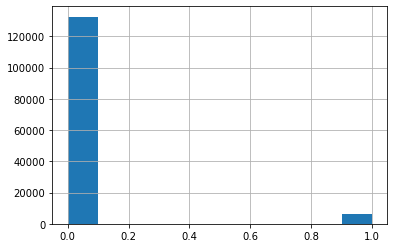

In [9]:
data.NextLegBunchingFlag.hist()

<AxesSubplot:>

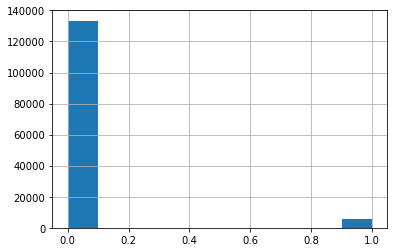

In [10]:
data.NextNextLegBunchingFlag.hist()

<AxesSubplot:>

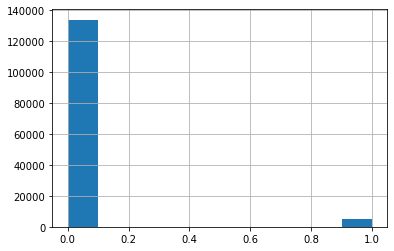

In [11]:
data.NextNextNextLegBunchingFlag.hist()

In [12]:
# Convert all columns to numeric column and separate out the target variable
X, y, nas  = proc_df(data, y_fld ='NextLegBunchingFlag',skip_flds=['NextNextLegBunchingFlag',\
                     'NextNextNextLegBunchingFlag'])

In [13]:
X.head()

,VehicleNo,Week,BlockNo,Pattern,StopName,ArriveLoadCompensated,OnsLoadCompensated,OffsLoadCompensated,LeaveLoadCompensated,WCLiftActivated,...,OperationIs_quarter_end,OperationIs_quarter_start,OperationIs_year_end,OperationIs_year_start,OperationElapsed,Boxing Day,Mon-Fri,Saturday,Sunday/Holidays,XMAS Day
0,2553,35,34132,1,0.019916,1,0,0,1,1,...,False,False,False,False,1472688000,0,1,0,0,0
1,2553,35,34132,1,0.024084,1,1,0,2,1,...,False,False,False,False,1472688000,0,1,0,0,0
2,2553,35,34132,1,0.000000,2,0,0,2,1,...,False,False,False,False,1472688000,0,1,0,0,0
3,2553,35,34132,1,0.039178,-1,0,0,-1,1,...,False,False,False,False,1472688000,0,1,0,0,0
4,2553,35,34132,1,0.045411,-1,2,0,1,1,...,False,False,False,False,1472688000,0,1,0,0,0


In [15]:
from sklearn.preprocessing import StandardScaler

In [18]:
X.head()

,VehicleNo,Week,BlockNo,Pattern,StopName,ArriveLoadCompensated,OnsLoadCompensated,OffsLoadCompensated,LeaveLoadCompensated,WCLiftActivated,...,OperationIs_quarter_end,OperationIs_quarter_start,OperationIs_year_end,OperationIs_year_start,OperationElapsed,Boxing Day,Mon-Fri,Saturday,Sunday/Holidays,XMAS Day
0,2553,35,34132,1,0.019916,1,0,0,1,1,...,False,False,False,False,1472688000,0,1,0,0,0
1,2553,35,34132,1,0.024084,1,1,0,2,1,...,False,False,False,False,1472688000,0,1,0,0,0
2,2553,35,34132,1,0.000000,2,0,0,2,1,...,False,False,False,False,1472688000,0,1,0,0,0
3,2553,35,34132,1,0.039178,-1,0,0,-1,1,...,False,False,False,False,1472688000,0,1,0,0,0
4,2553,35,34132,1,0.045411,-1,2,0,1,1,...,False,False,False,False,1472688000,0,1,0,0,0


In [21]:
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X), columns=X.columns)

### Imbalanced class, use stratified sampling for train, test and validation sets

In [22]:
# Shuffle and split the data into training and testing subsets
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X_scaled, y,  random_state =1, \
                                                                test_size=0.20,stratify = y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid,  random_state =1, \
                                                                test_size=0.50,stratify = y_test_valid)

In [23]:
#Look at distribution of targets in train, test and validation set
print('train:',np.unique(y_train,return_counts=True))
print('test:',np.unique(y_test,return_counts=True))
print('valid:',np.unique(y_valid,return_counts=True))

train: (array([0, 1]), array([106071,   4930]))
test: (array([0, 1]), array([13259,   616]))
valid: (array([0, 1]), array([13260,   616]))


### Model the data. First try RandomForest

In [24]:
from sklearn.ensemble import RandomForestClassifier
%time RFmodel = RandomForestClassifier(random_state=0,criterion='gini',\
                                       n_jobs=-1,oob_score=True)
%time RFmodel.fit(X_train,y_train)
#print_scores(RFmodel)

CPU times: user 90 µs, sys: 24 µs, total: 114 µs
Wall time: 131 µs
CPU times: user 59.1 s, sys: 726 ms, total: 59.8 s
Wall time: 46.5 s


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=0)

### Try Feature selection

In [25]:
from sklearn.inspection import permutation_importance

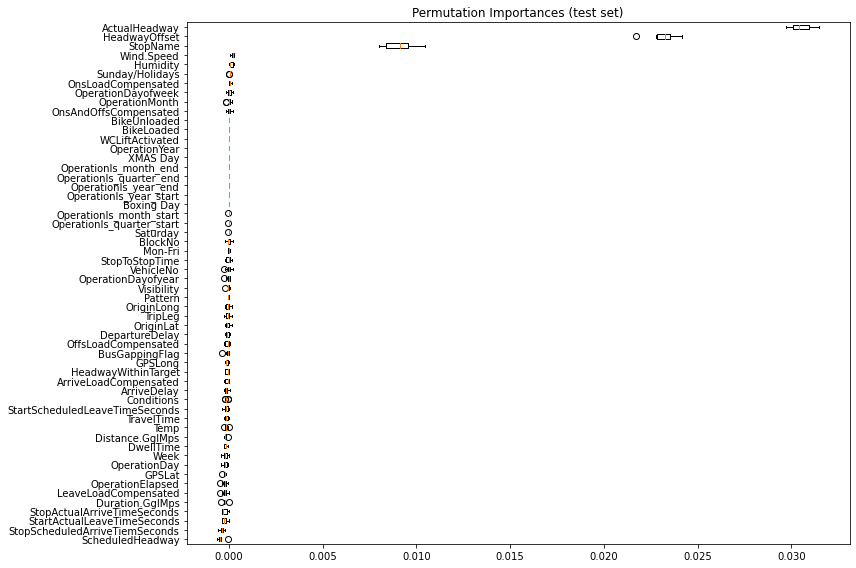

In [27]:
result = permutation_importance(RFmodel, X_test, y_test, n_repeats=10,random_state=0)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [37]:
pp=X_test.columns[sorted_idx[-8:]]

In [41]:
pp

Index(['OperationDayofweek', 'OnsLoadCompensated', 'Sunday/Holidays',
       'Humidity', 'Wind.Speed', 'StopName', 'HeadwayOffset', 'ActualHeadway'],
      dtype='object')

In [42]:
ll =[i for i in pp]

In [43]:
ll

['OperationDayofweek',
 'OnsLoadCompensated',
 'Sunday/Holidays',
 'Humidity',
 'Wind.Speed',
 'StopName',
 'HeadwayOffset',
 'ActualHeadway']

In [47]:
X_test[ll]

,OperationDayofweek,OnsLoadCompensated,Sunday/Holidays,Humidity,Wind.Speed,StopName,HeadwayOffset,ActualHeadway
14728,0.161841,3.084930,-0.309553,-1.506452,0.621879,0.210747,0.421328,-0.607741
99739,-1.503481,2.580469,-0.309553,0.100193,-0.291360,0.288088,-0.014429,-0.412421
86425,-1.503481,1.571547,-0.309553,1.328803,-1.335061,0.048713,0.156895,-0.529279
100433,-0.948373,-0.446297,-0.309553,0.950769,1.143730,0.823692,-0.148508,0.549153
18399,1.827163,-0.446297,3.230467,-1.222927,0.621879,0.316003,2.745365,-0.747971
...,...,...,...,...,...,...,...,...
96835,1.827163,-0.446297,3.230467,0.383718,1.535118,-2.161386,0.391533,0.307090
12081,0.161841,0.562625,-0.309553,-1.222927,1.665581,0.320765,1.047030,-0.387380
36973,0.161841,-0.446297,-0.309553,1.234295,-1.204598,-0.026556,-0.066571,-0.389050
113521,-0.393266,0.562625,-0.309553,-3.207606,-1.204598,-2.161386,-0.759312,-0.078541


In [17]:
# Make predictions on the training data
y_pred_train= RFmodel.predict(X_train)
y_pred_train_proba = RFmodel.predict_proba(X_train)
# Make predictions on the test data
y_pred_test= RFmodel.predict(X_test)
y_pred_test_proba = RFmodel.predict_proba(X_test)

### Visualize the results

#### Train

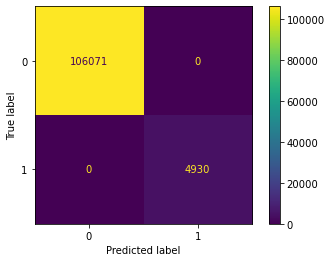

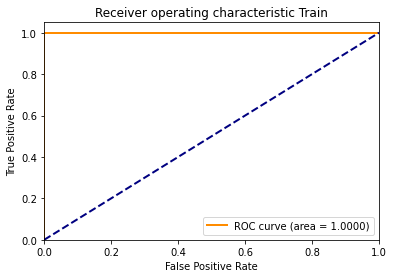

Accuracy score: 1.0000
MCC score: 1.0000
F-score: 1.0000


In [18]:
# Use the plot and score module that has codes for plotting and scoring
ps_train = plots_and_scores(y_train,y_pred_train, y_pred_train_proba) # Instantiate an object 
ps_train.display_confusion_matrix()
ps_train.plot_ROC('Train')
ps_train.print_scores()

#### Test

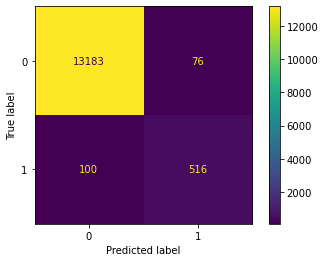

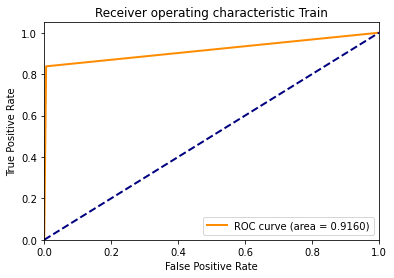

Accuracy score: 0.9873
MCC score: 0.8479
F-score: 0.8646


In [19]:
ps_test = plots_and_scores(y_test,y_pred_test, y_pred_test_proba) # Instantiate an object 
ps_test.display_confusion_matrix()
ps_test.plot_ROC('Train')
ps_test.print_scores()

### Looks like the model is overfitting.
- Good MCC score on training data, not so good on test data
- Grid search parameters.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from pprint import pprint

In [23]:
RFmodel = RandomForestClassifier(random_state=0,criterion='gini',\
                                       n_jobs=-1,oob_score=True,n_estimators=100)
# Create the parameters list to tune, using a dictionary if needed.
parameters = {'min_samples_leaf': [2],'max_features':[0.5],\
                    'max_samples':[0.6]}
# Make an mcc_Metric scoring object using make_scorer()
scorer = make_scorer(mcc_Metric, greater_is_better=True)
# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
print("In instantiate now ....")
%time grid_obj = GridSearchCV(RFmodel, parameters, scoring = scorer,n_jobs =-1)
# Fit the grid search object to the training data and find the optimal parameters using fit()
print("In fit now ....")
%time grid_fit = grid_obj.fit(X_train, y_train)
# Get the estimator
best_clf = grid_fit.best_estimator_
# Make predictions using the unoptimized model
print("In unoptimized fit now ....")
%time Unoptimizedpredictions = (RFmodel.fit(X_train, y_train)).predict(X_test)

# Make predictions using the optimized and model
best_predictions = best_clf.predict(X_test)
print('Results--------------\n')
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("MCC score on testing data: {:.4f}".format(mcc_Metric(y_test, Unoptimizedpredictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, Unoptimizedpredictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final MCC score on the testing data: {:.4f}".format(mcc_Metric(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
best_clf

In instantiate now ....
CPU times: user 56 µs, sys: 1 µs, total: 57 µs
Wall time: 60.8 µs
In fit now ....
CPU times: user 2min 31s, sys: 862 ms, total: 2min 32s
Wall time: 3min 28s
In unoptimized fit now ....
CPU times: user 55.8 s, sys: 365 ms, total: 56.2 s
Wall time: 16.8 s
Results--------------

Unoptimized model
------
MCC score on testing data: 0.8479
F-score on testing data: 0.8646

Optimized Model
------
Final MCC score on the testing data: 0.8543
Final F-score on the testing data: 0.8658


RandomForestClassifier(max_features=0.5, max_samples=0.6, min_samples_leaf=2,
                       n_jobs=-1, oob_score=True, random_state=0)

### ROC Curves

In [ ]:
plot_ROC(y_test, best_predictions)

In [ ]:
%time un_opt_model = RFmodel.fit(X_train, y_train)
Unopt_pred_train =un_opt_model.predict(X_train)

### Random Search parameters

In [ ]:
from scipy.stats import truncnorm, uniform
from random import randint

# create random forest classifier model
rf_model = RandomForestClassifier(n_jobs=-1)
model_params = dict(
    # randomly sample numbers from 4 to 204 estimators
    n_estimators=[randint(100,250)],
    #n_estimators =[80,100],
    #normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    #max_features=truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    max_features = [0.3,0.5],
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    #min_samples_split=uniform(0.01, 0.399),
    #uniform distribution from 0.5 to 0.99 (0.5 + 0.99)
    #max_samples=uniform(0.5,0.49),
    max_samples= [0.8,0.9],
    min_samples_leaf=[2,3,5]
)
#Set up the random search estimator, this will train 5 models.
clf = RandomizedSearchCV(rf_model, model_params, n_iter = 10,random_state=0,scoring = scorer)
print("In fit now")
%time model_rs = clf.fit(X_train, y_train)
# Get the best estimator
best_clf_rs = model_rs.best_estimator_
#Make predictions using the unoptimized
#predictions_UO = (RFmodel.fit(X_train, y_train)).predict(X_test)
#Make predictions using the optimized
best_pred_rs_train = best_clf_rs.predict(X_train)
best_pred_rs = best_clf_rs.predict(X_test)

# Report the before-and-afterscores
print('Results--------------\n')
print("Unoptimized model\n------")
print("MCC score on training data: {:.4f}".format(mcc_Metric(y_train, Unopt_pred_train)))
print("MCC score on testing data: {:.4f}".format(mcc_Metric(y_test, Unoptimizedpredictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, Unoptimizedpredictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final MCC score on the testing data: {:.4f}".format(mcc_Metric(y_train, best_pred_rs_train)))
print("Final MCC score on the testing data: {:.4f}".format(mcc_Metric(y_test, best_pred_rs)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_pred_rs, beta = 0.5)))
# Print the best parameters
pprint(model_rs.best_estimator_.get_params())

In [ ]:
clf.scorer_

In [ ]:
plot_ROC(y_test,best_predictions_rs)

#### Saving the models
- Unoptimized model. 
- Optimized model.

In [ ]:
import joblib

In [ ]:
joblib.dump(model_rs,'Random_forest_optimized.joblib')
joblib.dump(RFmodel,'Random_forest_not_optimized.joblib')

In [ ]:
load_RF = joblib.load('Random_forest.joblib')

In [ ]:
y_pd = load_RF.predict(X_test)
print("Final MCC score on the testing data: {:.4f}".format(mcc_Metric(y_test, y_pd)))

#### Feature importance.
- Use permutation importance on the test set

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
result = permutation_importance(load_RF, X_test, y_test, n_repeats=10,random_state=0)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Choose top 8 features . For the rest of the analysis we will use this features for modelling 

In [ ]:
X_test.columns[sorted_idx[-8:]]

In [ ]:
X_test_features = X_test[['Temp', 'DwellTime', 'OnsAndOffsCompensated', 'ArriveLoadCompensated',\
       'ArriveDelay', 'StopName', 'HeadwayOffset', 'ActualHeadway']]

X_train_features = X_train[['Temp', 'DwellTime', 'OnsAndOffsCompensated', 'ArriveLoadCompensated',\
       'ArriveDelay', 'StopName', 'HeadwayOffset', 'ActualHeadway']]

X_valid_features = X_valid[['Temp', 'DwellTime', 'OnsAndOffsCompensated', 'ArriveLoadCompensated',\
       'ArriveDelay', 'StopName', 'HeadwayOffset', 'ActualHeadway']]

### Train model on the top 8 features

In [ ]:
import time
def RandomtuneRF(X_tr, y_tr, X_test, y_test):
    # This returns best_pred_train, best_pred_test, model
    # create random forest classifier model
    model = RandomForestClassifier(n_jobs=-1)
    model_params = dict(
    # randomly sample numbers from 4 to 204 estimators
        n_estimators=[randint(100,200)],
    #n_estimators =[80,100],
    #normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    #max_features=truncnorm(a=0, b=1, loc=0.25, scale=0.1),
        max_features = [0.3,0.5],
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    #min_samples_split=uniform(0.01, 0.399),
    #uniform distribution from 0.5 to 0.99 (0.5 + 0.99)
    #max_samples=uniform(0.5,0.49),
        max_samples= [0.8,0.9],
        min_samples_leaf=[2,3,5]
    )
#Set up the random search estimator, this will train 5 models.
    clf = RandomizedSearchCV(model, model_params, n_iter = 3,random_state=0,scoring = scorer)
    print("In fit now--------\n")
    t = time.process_time()
    fit_model = clf.fit(X_tr, y_tr)
    elapsed_time = time.process_time() - t
    print("Time to fit: {:.4f} s".format(elapsed_time))
# Get the best estimator
    best_clf = fit_model.best_estimator_
#Make predictions using the unoptimized
#predictions_UO = (RFmodel.fit(X_train, y_train)).predict(X_test)
#Make predictions using the optimized
    best_pred_train = best_clf.predict(X_tr)
    best_pred_test = best_clf.predict(X_test)
    return fit_model,best_pred_train, best_pred_test
    # Print the best parameters
    pprint(model_rs.best_estimator_.get_params())
    
def compare_models(y_train,y_test,Unopt_pred_train,Unoptimizedpredictions,best_pred_train,best_pred_test):
#Report the before-and-afterscores
    print('Results--------------\n')
    print("Unoptimized model\n------")
    print("MCC score on training data: {:.4f}".format(mcc_Metric(y_train, Unopt_pred_train)))
    print("MCC score on testing data: {:.4f}".format(mcc_Metric(y_test, Unoptimizedpredictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, Unoptimizedpredictions, beta = 0.5)))
    print("\nOptimized Model\n------")
    print("Final MCC score on the training data: {:.4f}".format(mcc_Metric(y_train, best_pred_train)))
    print("Final MCC score on the testing data: {:.4f}".format(mcc_Metric(y_test, best_pred_test)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_pred_test, beta = 0.5)))
    plot_ROC(y_test,best_pred_test)

In [ ]:
fit_model,best_pred_train, best_pred_test = RandomtuneRF(X_train_features, y_train, X_test_features, y_test)
compare_models(y_train,y_test,Unopt_pred_train,Unoptimizedpredictions,best_pred_train,best_pred_test)

### Save the fitted model

In [ ]:
import joblib
joblib.dump(fit_model,'Random_forest_optimized_8_features.joblib')

#### Put everything in a class.

In [ ]:
class RFmodel:
    """ Runs Random forest """
    def __init__(self):
        self.random_forest = RandomForestClassifier(n_jobs=-1,criterion ='gini')
    
    def unoptimized_RF(self,X, y):
    """ 
    Trains a model with default parameters and returns the model
    Parameter
    ---------
    X : input features
    y : target
    
    Returns
    --------
    un_opt_model: trained model
    
    """
        self.X = X
        self.y = y
        print("In unoptimized fit now--------")
        t = time.process_time()
        un_opt_model = self.random_forest.fit(self.X, self.y)
        elapsed_time = time.process_time() - t
        print("Time taken to fit: {:.4f} s".format(elapsed_time))
        print('\n')
        #un_opt_pred =un_opt_model.predict(self.X)
        return un_opt_model  
    
    def randomtuned_RF(self, X_train, y_train):
    """ 
    Trains a model using random parameters and returns the model
    Parameter
    ---------
    X : input features
    y : target
    
    Returns
    --------
    best_clf : trained model
    
    """
        self.X_train = X_train
        self.y_train = y_train
        # create random forest classifier model
        model = self.random_forest
        model_params = dict(
    # randomly sample numbers from 4 to 204 estimators
            n_estimators=[randint(120,200)],
    #n_estimators =[80,100],
    #normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    #max_features=truncnorm(a=0, b=1, loc=0.25, scale=0.1),
            max_features = [0.3,0.5,0.8],
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    #min_samples_split=uniform(0.01, 0.399),
    #uniform distribution from 0.5 to 0.99 (0.5 + 0.99)
    #max_samples=uniform(0.5,0.49),
            max_samples= [0.8,0.9,0.99],
            min_samples_leaf=[2,3,5]
        )
#Set up the random search estimator, this will train 5 models.
        clf = RandomizedSearchCV(model, model_params, n_iter = 5,random_state=0,scoring = scorer)
        print("In randomtune fit now--------")
        t = time.process_time()
        fit_model = clf.fit(self.X_train, self.y_train)
        elapsed_time = time.process_time() - t
        print("Time taken to fit: {:.4f} s".format(elapsed_time))
        print('\n')
        # Get the best estimator
        best_clf = fit_model.best_estimator_
        #Print the best parameters
        #pprint(fit_model.best_estimator_.get_params())
        return best_clf
    

        # Compute ROC curve and ROC area for each class
    def plot_ROC(self,y,y_pred,name):
        self.y = y
        self.y_pred = y_pred
        self.name = name
        n_classes = 1
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y, self.y_pred)
            roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(self.y.ravel(), self.y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.figure()
        lw = 2
        plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[0])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic %s'%name)
        plt.legend(loc="lower right")
        plt.show()
        
    def scores(self,y,y_pred):
        #Takes prdictions from two models and outputs the MCC score and f beta score
        self.y = y
        self.y_pred = y_pred
      #Report the before-and-afterscores
        print("Accuracy score: {:.4f}".format(accuracy_score(self.y, self.y_pred)))
        print("MCC score: {:.4f}".format(mcc_Metric(self.y,self.y_pred)))
        print("F-score: {:.4f}".format(fbeta_score(self.y, self.y_pred, beta = 0.5)))
           

In [ ]:
# Here we return the models
rf_model = RFmodel()
# First train a base model with default parameters.
base_model = rf_model.unoptimized_RF(X_train_features,y_train)
# Now train a model to optimize parameters.
optimized_model = rf_model.randomtuned_RF(X_train_features,y_train)

In [ ]:
#Optimized model
y_pred_train = optimized_model.predict(X_train_features)
y_pred_test = optimized_model.predict(X_test_features)

y_pred_train_base = base_model.predict(X_train_features)
y_pred_test_base = base_model.predict(X_test_features)
#Try optimized model
print("Optimized model-------")
print("Train score:-->")
rf_model.scores(y_train,y_pred_train)
#rf_model.plot_ROC(y_train[:2000],y_pred_train,'optimized model, train')
print("\n Test score:-->")
rf_model.scores(y_test,y_pred_test)
rf_model.plot_ROC(y_test,y_pred_test,'optimized model, test')
print("Not optimized model--------")
print("Train score:-->")
#Try not optimized model
rf_model.scores(y_train,y_pred_train_base)
#rf_model.plot_ROC(y_train[:2000],y_pred_train_base,'Not optimized model, train')
print("\n Test score:-->")
rf_model.scores(y_test,y_pred_test_base)
rf_model.plot_ROC(y_test,y_pred_test_base,'Not optimized model, test')

In [ ]:
joblib.dump(optimized_model,'Random_forest_optimized_8_features.joblib')

### Now try Logisitic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve

class log_reg_model():
    
    def __init__(self, X,y):
        self.log_reg = LogisticRegression(max_iter=1000, C=100000,penalty = 'l2')
        self.X = X
        self.y = y
        
    def unoptimized_LR(self):
       #takes in X and y and trains a model with default parameters and returns the model
        print("In unoptimized fit now--------")
        t = time.process_time()
        un_opt_model = self.log_reg.fit(self.X, self.y)
        elapsed_time = time.process_time() - t
        print("Time taken to fit: {:.4f} s".format(elapsed_time))
        print('\n')
        #un_opt_pred =un_opt_model.predict(self.X)
        return un_opt_model
    
    
class plot_and_scores():
    """ 
    Input 
    ---------
    y : actual target values
    y_pred : predicted target  values 
    y_pred_proba : predicted probabilities  
    
    """
    def __init__(self,y,y_pred, y_pred_proba):
        self.y = y
        self.y_pred = y_pred
        self.y_pred_proba = y_pred_proba
        
    def plot_ROC(self,name):
        self.name = name
        n_classes = 1
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y, self.y_pred)
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(self.y.ravel(), self.y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.figure()
        lw = 2
        plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[0])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic %s'%name)
        plt.legend(loc="lower right")
        plt.show()
        
    def print_scores(self):
        print("Accuracy score: {:.4f}".format(accuracy_score(self.y, self.y_pred)))
        print("MCC score: {:.4f}".format(mcc_Metric(self.y,self.y_pred)))
        print("F-score: {:.4f}".format(fbeta_score(self.y, self.y_pred, beta = 0.5)))
    
    
    def mcc_Metric(self):
        
        cf_matrix=confusion_matrix(self.y,self.y_preds)
        TP = cf_matrix[0][0]
        TN = cf_matrix[1][1]
        FN = cf_matrix[0][1]
        FP = cf_matrix[1][0]
        N = TN + TP + FN + FP 
        S = (TP + FN)/N
        P = (TP + FP)/N
        num = (TP /N) - (S*P)
        deno = np.sqrt(P*S*(1-S)*(1-P))
        
        #Need to avoide division by zero
        return weird_division(num,deno)
    
    def display_confusion_matrix(self):
        cm = confusion_matrix(self.y, self.y_pred)
        ConfusionMatrixDisplay(cm).plot() 
        

    def weird_division(self,n, d):
        self.n = n
        self.d = d
        return self.n / self.d if self.d else 0  
   
   
    def precision_recall_vs_threshold(self):
        precisions, recalls, thresholds = precision_recall_curve(self.y,self.y_pred_proba[:,1])
        plt.figure()
        plt.title("Precision-Recall vs Threshold Chart")
        plt.plot(thresholds, precisions[: -1], "b--", label="Precision")
        plt.plot(thresholds, recalls[: -1], "r--", label="Recall")
        plt.ylabel("Precision, Recall")
        plt.xlabel("Threshold")
        plt.legend(loc="lower left")
        plt.ylim([0,1])
        plt.show() 

In [ ]:
from sklearn.preprocessing import StandardScaler
X1 = StandardScaler().fit_transform(X_train_features)

In [ ]:
X1.shape

In [ ]:
# Here we return the models
log_r_model = log_reg_model(X1,y_train)
# First train a base model with default parameters.
base_model_LR = log_r_model.unoptimized_LR()

In [ ]:
#Make predictions
y_pred_LR = base_model_LR.predict(X1)
y_pred_proba = base_model_LR.predict_proba(X1)
#y_pred_test_base = base_model.predict(X_test_features)
ps = plot_and_scores(y_train,y_pred_LR,y_pred_proba)
ps.print_scores()
ps.plot_ROC('test')
ps.display_confusion_matrix()
ps.precision_recall_vs_threshold()

In [ ]:
y_pred_LR_prob = base_model_LR.predict_proba(X1)

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train,y_pred_LR_prob[:,1])

In [ ]:
print('precision shape',precisions.shape, 'threshold shape',thresholds.shape,'recalls shape',recalls.shape)

In [ ]:
111001-110752

In [ ]:
# probs_y is a 2-D array of probability of being labeled as 0 (first column of #array) vs 1 (2nd column in array)

#precision, recall, thresholds = precision_recall_curve(y_train,y_pred_LR_prob[:,1]) 
#retrieve probability of being 1(in second column of probs_y)
#pr_auc = metrics.auc(recall, precision)
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precisions[: -1], "b--", label="Precision")
plt.plot(thresholds, recalls[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [ ]:
plt.plot(precision,recall)

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    #plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
#plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
#plt.plot([0.4368], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

In [ ]:
#Plot scatter matrix for all features
#params = ["HeadwayOffset","Temp", "Windspeed","Dwell Time"]
#pd.scatter_matrix(X_train, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
#plt.savefig("scatter.png")

In [ ]:
from sklearn.metrics import fbeta_score, accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [ ]:
import visuals as vs

In [ ]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import time

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=0)
clf_B = DecisionTreeClassifier(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(X_train)
samples_10 = int(0.1 * len(X_train))
samples_1 = int(0.01 * len(X_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [ ]:
X_train.iloc[1]

In [ ]:
#plt.hist(labels[:300],bins=2)

In [ ]:
import visuals as vs
importances = RFmodel.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits=10, test_size = 0.20, random_state=None)

    # TODO: Create a decision tree regressor object
    classifier = RandomForestClassifier()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': range(1,10), 'n_estimators':[10,50,100,200]}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(accuracy_score)

    # TODO: Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(classifier, params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [ ]:

reg = fit_model(X_train, y_train.values.ravel())

# Produce the value for 'max_depth'


print ("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))
print ("Parameter 'n_estimators' is {} for the optimal model.".format(reg.get_params()['n_estimators']))